In [ ]:
## Standard libraries, imported from test notebook https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/Meta_Learning.ipynb
import os
import numpy as np
import random
from pathlib import Path
from random import sample
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
from torch.utils.data import Dataset

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
from torchvision import transforms
import torch_directml

from torchvision.transforms import (
    Grayscale, ToTensor, Compose, Resize, InterpolationMode, Normalize, Lambda
)
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial16"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch_directml.device()
print("Device:", device)

C:\Users\bpele\AppData\Local\Temp\ipykernel_9408\3074855280.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
C:\Users\bpele\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


Device: privateuseone:0


<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision.transforms import Compose, ToTensor, Grayscale, Resize, Normalize, InterpolationMode, RandomCrop

class LanguageDataset(Dataset):
    """
    A PyTorch Dataset class for few-shot learning using spectrogram images of radio signals.

    This dataset:
    - Organizes data into episodes for few-shot learning.
    - Each episode returns a support set and a query set.
    - Applies preprocessing transformations (grayscale conversion, resizing, normalization).

    Attributes:
    ----------
    data_dir : str
        Path to the dataset directory.
    episodes_per_epoch : int
        Number of episodes per epoch.
    num_support : int
        Number of support samples per class.
        X shot learning
    num_query : int
        Number of query samples per class.
    augment : bool
        Apply time and frequency masking to spectrograms
    """

    def __init__(self, data_dir, num_support=10, num_query=5, episodes_per_epoch=100, augment=True):
        self.data_dir = data_dir
        self.class_labels = ['arabic', 'english', 'german', 'mandarin', 'spanish', 'garbage', 'french']
        self.num_support = num_support
        self.num_query = num_query
        self.episodes_per_epoch = episodes_per_epoch
        self.augment = augment
        self.random_crop = RandomCrop(size=(224, 224))  # assuming final size

        self.transform = Compose([
            ToTensor(),
            Grayscale(num_output_channels=3),
            Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
            Normalize(mean=[0.5], std=[0.5])
        ])

        self.data_by_class = {label: [] for label in self.class_labels}
        all_files = os.listdir(data_dir)

        for file_name in all_files:
            for label in self.class_labels:
                if file_name.startswith(label):
                    self.data_by_class[label].append(file_name)
                    break
        


    def __len__(self):
        return self.episodes_per_epoch

    def __getitem__(self, idx):
        # Randomly select N classes
        selected_classes = random.sample(self.class_labels, k=min(len(self.class_labels), 7))  # N-way

        support_images, support_labels = [], []
        query_images, query_labels = [], []

        for class_idx, class_label in enumerate(selected_classes):
            file_list = self.data_by_class[class_label]
            sampled_files = random.sample(file_list, self.num_support + self.num_query)
            support_files = sampled_files[:self.num_support]
            query_files = sampled_files[self.num_support:]

            for file in support_files:
                image = self.load_image(os.path.join(self.data_dir, file))
                support_images.append(image)
                support_labels.append(class_idx)

            for file in query_files:
                image = self.load_image(os.path.join(self.data_dir, file))
                query_images.append(image)
                query_labels.append(class_idx)

        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels, dtype=torch.long)
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels, dtype=torch.long)

        return support_images, support_labels, query_images, query_labels

    def load_image(self, file_path):
        image = Image.open(file_path)
        image = image.transpose(Image.ROTATE_90)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        image = self.random_crop(image)
        
       # Convert image to spectrogram (numpy array) and apply augmentation
        spectrogram = np.array(image)

        if self.augment:
            spectrogram = self.apply_spec_augment(spectrogram)

        # Convert to tensor and apply transformations
        image_tensor = self.transform(Image.fromarray(spectrogram))

        if self.augment:
            image_tensor = self.apply_noise(image_tensor)
        return image_tensor
    
    def apply_spec_augment(self, spectrogram):
        """Apply SpecAugment (time and frequency masking)"""
        # Apply time and frequency masking for data augmentation
        spectrogram = self.time_mask(spectrogram)
        spectrogram = self.freq_mask(spectrogram)
        return spectrogram

    def time_mask(self, spectrogram, max_mask_size=50):
        """Apply time masking to the spectrogram"""
        n_frames = spectrogram.shape[1]
        mask_start = random.randint(0, n_frames - max_mask_size)
        mask_end = mask_start + random.randint(1, max_mask_size)
        spectrogram[:, mask_start:mask_end] = 0
        return spectrogram

    def freq_mask(self, spectrogram, max_mask_size=10):
        """Apply frequency masking to the spectrogram"""
        n_freqs = spectrogram.shape[0]
        mask_start = random.randint(0, n_freqs - max_mask_size)
        mask_end = mask_start + random.randint(1, max_mask_size)
        spectrogram[mask_start:mask_end, :] = 0
        return spectrogram
    
    def apply_noise(self, img_tensor, noise_level=0.03):
        noise = torch.randn_like(img_tensor) * noise_level
        return torch.clamp(img_tensor + noise, 0.0, 1.0)  # Keep within valid image range


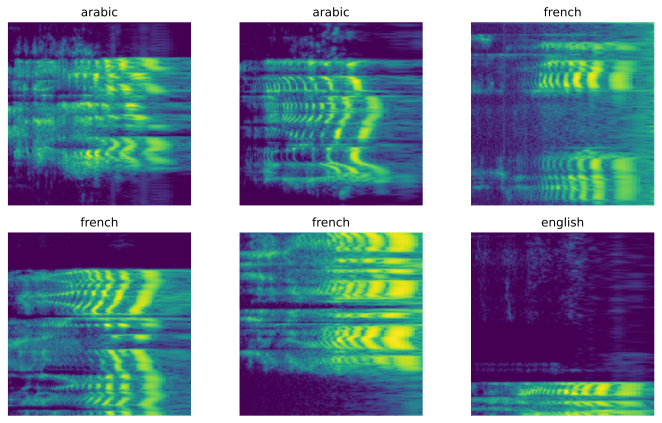

In [ ]:
# Define the dataset path (Update if the path is different)
data_dir2 = Path("languages")

# List all spectrogram files in the directory
spectrogram_filenames = os.listdir(data_dir2)
# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(spectrogram_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    spectrogram_path = os.path.join(data_dir2, selected_files[i])
    spectrogram = np.array(Image.open(spectrogram_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    spectrogram = np.squeeze(spectrogram)
    # Display the spectrogram
    ax.imshow(spectrogram, cmap="viridis")  # Ensuring a grayscale colormap
    ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
# Fixed parameters
task = 'languages'
task_type = "classification"

# Configurable parameters
#set device to use local AMD GPU
device = torch_directml.device()
train_test_split = 0.8
batch_size = 4
num_workers = 0
frozen_blocks = 0
label_smoothing = 0
lr = 1e-3#1e-2
weight_decay = 0.05
layer_decay = 0.75
model_size = 'small'
epochs = 20#50#10
warmup_epochs = 2#10#2#1
output_dir = 'models'

In [5]:

dataset = LanguageDataset(Path('languages'), num_support=2, num_query=10, episodes_per_epoch=400)  # Update path if needed
# Set random seed for reproducibility
seed = 42

# ⁉️Replace the line below with your stratified split implementation
dataset_train, dataset_val = random_split(dataset, [0.8, 0.2],
                                          generator=torch.Generator().manual_seed(seed))

# Create dataloaders
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,
                               pin_memory=True, drop_last=True)
data_loader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers,
                             pin_memory=True, drop_last=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#custom CNN encoder backend for image data
class CNNEncoder(nn.Module):
    def __init__(self, input_channels=3, embedding_dim=256):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
    
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial size by half each time
    
        # Compute FC input size dynamically
        dummy_input = torch.randn(1, input_channels, 224, 224)
        with torch.no_grad():
            dummy_out = self.extract_features(dummy_input)
        fc_input_size = dummy_out.view(1, -1).shape[1]
    
        self.fc = nn.Linear(fc_input_size, embedding_dim)
    
    def extract_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        return x  # Return feature maps before FC


    def forward(self, x):
        x = self.extract_features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Fully connected layer
        return F.normalize(x, p=2, dim=1)



In [6]:
import torchvision.models as models
import torch.nn as nn

class CNNEncoder_resnet(nn.Module):
    def __init__(self):
        super(CNNEncoder_resnet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove final classification layer
        self.output_dim = 512  # ResNet18 outputs 512-dim embeddings

    def forward(self, x):
        return self.resnet(x)


In [ ]:
import torchvision.models as models
import torch.nn as nn

class CNNEncoder_mobilenet(nn.Module):
    def __init__(self):
        super(CNNEncoder_mobilenet, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)

    def forward(self, x):
        return self.mobilenet(x)

In [ ]:
def compute_prototypes(encoder, support_images, support_labels):
    """
    Computes class prototypes as the mean of support set embeddings.
    """
    batch_size, num_support, C, H, W = support_images.shape
    support_images = support_images.view(batch_size * num_support, C, H, W)
    
    embeddings = encoder(support_images)  # Compute embeddings
    embeddings = embeddings.view(batch_size, num_support, -1)

    # Normalize embeddings before computing prototypes
    embeddings = nn.functional.normalize(embeddings, p=2, dim=-1)

    class_prototypes = {}
    for cls in torch.unique(support_labels):
        mask = (support_labels == cls).unsqueeze(-1).expand_as(embeddings)
        prototype = embeddings[mask].view(-1, embeddings.shape[-1]).mean(dim=0)
        class_prototypes[cls.item()] = prototype

    return class_prototypes



In [ ]:
def classify_query(encoder, query_images, class_prototypes):
    """
    Classifies query images by computing distances to class prototypes.
    """
    batch_size, num_query, C, H, W = query_images.shape

    # Reshape query images to match Conv2D expected input
    query_images = query_images.view(batch_size * num_query, C, H, W)

    # Get embeddings
    query_embeddings = encoder(query_images)
    
    # Reshape embeddings back to [batch_size, num_query, embedding_dim]
    embedding_dim = query_embeddings.shape[-1]
    query_embeddings = query_embeddings.view(batch_size, num_query, embedding_dim)

    distances = []

    for cls, proto in class_prototypes.items():
        dist = torch.norm(query_embeddings - proto, dim=2)  # Euclidean distance
        distances.append(-dist.unsqueeze(2))  # Negative distances for softmax compatibility

    distances = torch.cat(distances, dim=2)

    return distances  # Return raw distances (not class indices)




In [ ]:
def evaluate(encoder, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed for evaluation
        for support_images, support_labels, query_images, query_labels in test_loader:
            # Compute class prototypes from support images
            prototypes = compute_prototypes(encoder, support_images, support_labels)

            # Classify query images
            predictions = classify_query(encoder, query_images, prototypes)

            # Flatten predictions to get the class with the highest probability for each query image
            predicted_classes = torch.argmax(predictions, dim=2)

            # Flatten the predictions and true labels to compare them
            predicted_classes = predicted_classes.view(-1)  # Flatten to [batch_size * num_query]
            query_labels_flat = query_labels.view(-1)  # Flatten to [batch_size * num_query]

            # Ensure predictions and query_labels have the same number of elements
            assert predicted_classes.size(0) == query_labels_flat.size(0), \
                f"Shape mismatch: {predicted_classes.size(0)} vs {query_labels_flat.size(0)}"

            # Compare predicted classes to true labels
            correct += (predicted_classes == query_labels_flat).sum().item()
            total += query_labels_flat.size(0)

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")








In [ ]:
#attempt encoder using resnet backend architecture
encoder = CNNEncoder_resnet()

#apply LR scaling through cosine annealing scheduler and different optimizer
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001, weight_decay=0.75)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)


for epoch in range(epochs):
    for support_images, support_labels, query_images, query_labels in data_loader_train:

        optimizer.zero_grad()
        
        # Compute class prototypes
        prototypes = compute_prototypes(encoder, support_images, support_labels)
        
        # Classify query images
        predictions = classify_query(encoder, query_images, prototypes)

        query_labels = query_labels.long()  # Ensure labels are of type Long

        # Reshape predictions and query_labels to match CrossEntropyLoss requirements
        predictions = predictions.view(-1, predictions.shape[-1])  # Flatten to [batch_size * num_query, num_classes]
        query_labels = query_labels.view(-1).long()  # Flatten to [batch_size * num_query]
        
        # Compute loss
        loss = loss_fn(predictions, query_labels)

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}: Loss = {loss.item()}")

torch.save(encoder, "models/prototypical_resnet18_language_2shot_20epoch.pth")


Epoch 1: Loss = 1.9147112369537354
Epoch 2: Loss = 1.8696891069412231
Epoch 3: Loss = 1.9301267862319946
Epoch 4: Loss = 1.905570149421692
Epoch 5: Loss = 1.9448699951171875
Epoch 6: Loss = 1.9109702110290527
Epoch 7: Loss = 1.8993107080459595
Epoch 8: Loss = 1.9044502973556519
Epoch 9: Loss = 1.9207016229629517
Epoch 10: Loss = 1.9332064390182495
Epoch 11: Loss = 1.932951807975769
Epoch 12: Loss = 1.9241069555282593
Epoch 13: Loss = 1.9118200540542603
Epoch 14: Loss = 1.9041004180908203
Epoch 15: Loss = 1.8838269710540771
Epoch 16: Loss = 1.9289798736572266
Epoch 17: Loss = 1.907870888710022
Epoch 18: Loss = 1.901938796043396
Epoch 19: Loss = 1.9176666736602783
Epoch 20: Loss = 1.901184320449829


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_with_confusion_matrix(encoder, data_loader_test, class_labels):
    """
    Evaluates the encoder and plots a confusion matrix.
    """
    encoder.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for evaluation
        for support_images, support_labels, query_images, query_labels in data_loader_test:
            # Compute class prototypes
            prototypes = compute_prototypes(encoder, support_images, support_labels)

            # Classify query images
            predictions = classify_query(encoder, query_images, prototypes)

            # Flatten and store predictions & true labels
            predictions = predictions.view(-1, 7)  # Flatten to [batch_size * num_query, num_classes]
            query_labels = query_labels.view(-1)  # Flatten to [batch_size * num_query]
            
            all_preds.extend(predictions.argmax(dim=1).cpu().numpy())  # Get the class with the highest score
            all_labels.extend(query_labels.cpu().numpy())

    # Ensure the lengths match
    assert len(all_preds) == len(all_labels), f"Mismatch: {len(all_preds)} vs {len(all_labels)}"

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return cm




Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened predictions.shape: torch.Size([280, 7])
Flattened query_labels.shape: torch.Size([280])
Flattened prediction

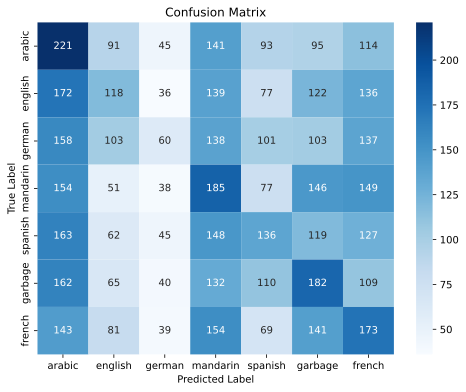

Accuracy: 20.70%


In [14]:
class_labels = ['arabic', 'english', 'german', 'mandarin', 'spanish', 'garbage', 'french']
evaluate_with_confusion_matrix(encoder, data_loader_val, class_labels)
evaluate(encoder, data_loader_val)


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def visualize_embeddings(encoder, data_loader, class_labels):
    """
    Extracts embeddings from the encoder and visualizes them using t-SNE.
    """
    encoder.eval()  # Set model to evaluation mode
    all_embeddings = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for evaluation
        for support_images, support_labels, query_images, query_labels in data_loader:
            # Get embeddings for query images
            batch_size, num_query, C, H, W = query_images.shape
            query_images = query_images.view(batch_size * num_query, C, H, W)
            embeddings = encoder(query_images)  # Extract features

            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(query_labels.view(-1).cpu().numpy())

    # Convert to NumPy arrays
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    # Plot embeddings
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=all_labels, palette="deep", legend='full')
    plt.title("t-SNE Visualization of Prototypical Network Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(class_labels)
    plt.show()


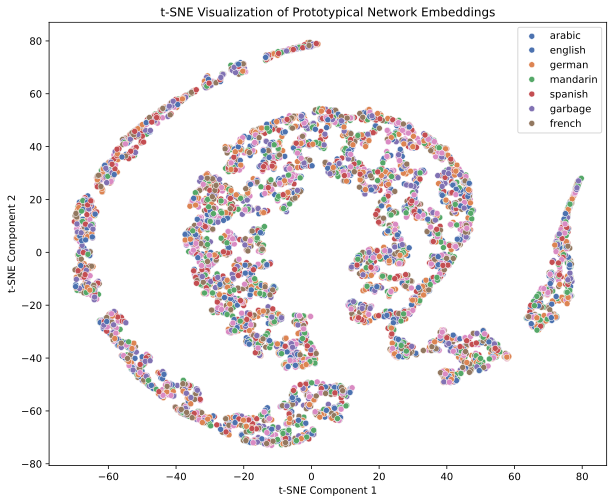

In [16]:
class_labels = ['arabic', 'english', 'german', 'mandarin', 'spanish', 'garbage', 'french']
visualize_embeddings(encoder, data_loader_val, class_labels)
